<a href="https://colab.research.google.com/github/Khawaritzmi/Deep-Learning/blob/master/ResNeXt50_Cocoa_Beans_100Epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/My Drive/Dataset Coklat/Dataset Coklat/Cocoa Beans/Whole_Beans_Cocoa"

/content/drive/My Drive/Dataset Coklat/Dataset Coklat/Cocoa Beans/Whole_Beans_Cocoa


%cd "/content/drive/My Drive/Dataset Coklat/Dataset Coklat/Cocoa Beans"

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [5]:
import numpy as np
import pickle
import cv2
import keras

from keras_applications.resnext import ResNeXt50
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.layers import BatchNormalization

from os import listdir
from keras import backend as K
from keras.layers import Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

Using TensorFlow backend.


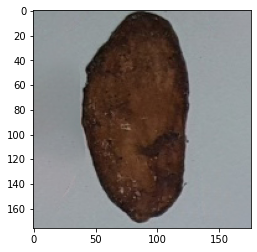

In [9]:
img = cv2.imread("WB01_104.jpg")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

In [0]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
directory_root = "/content/drive/My Drive/Dataset Coklat/Dataset Coklat"
width=224
height=224
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Unfermented_Cocoa ...
[INFO] Processing Moldy_Cocoa ...
[INFO] Processing Fermented_Cocoa ...
[INFO] Processing Bean_Fraction_Cocoa ...
[INFO] Processing Broken_Beans_Cocoa ...
[INFO] Processing Whole_Beans_Cocoa ...
[INFO] Image loading completed
CPU times: user 124 µs, sys: 34 µs, total: 158 µs
Wall time: 162 µs


In [0]:
image_size = len(image_list)

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [0]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
base_model = ResNeXt50(input_tensor=Input(shape = (width, height, depth)), include_top = False, weights = None, 
        backend = keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils)

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(1024, activation='relu')(x)
predictions = Dense(n_classes, activation= 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

In [0]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[INFO] training network...


In [0]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1)



Epoch 1/100
15/15 [==============================] - 40s 3s/step - loss: 0.9515 - acc: 0.7856 - val_loss: 4.3877 - val_acc: 0.7263
Epoch 2/100
15/15 [==============================] - 16s 1s/step - loss: 0.7710 - acc: 0.8015 - val_loss: 4.3008 - val_acc: 0.7317
Epoch 3/100
15/15 [==============================] - 16s 1s/step - loss: 0.3483 - acc: 0.8676 - val_loss: 4.5585 - val_acc: 0.7154
Epoch 4/100
15/15 [==============================] - 17s 1s/step - loss: 0.2907 - acc: 0.8774 - val_loss: 3.3553 - val_acc: 0.7371
Epoch 5/100
15/15 [==============================] - 16s 1s/step - loss: 0.3041 - acc: 0.8732 - val_loss: 3.6349 - val_acc: 0.7073
Epoch 6/100
15/15 [==============================] - 16s 1s/step - loss: 0.2901 - acc: 0.8846 - val_loss: 3.1473 - val_acc: 0.7344
Epoch 7/100
15/15 [==============================] - 17s 1s/step - loss: 0.2209 - acc: 0.8931 - val_loss: 2.4687 - val_acc: 0.7561
Epoch 8/100
15/15 [==============================] - 16s 1s/step - loss: 0.2622 -

In [0]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

123/123 [==============================] - 1s 7ms/step
Test Accuracy: 87.12737443970471


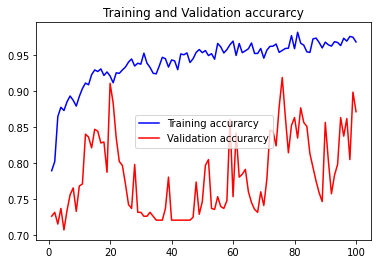

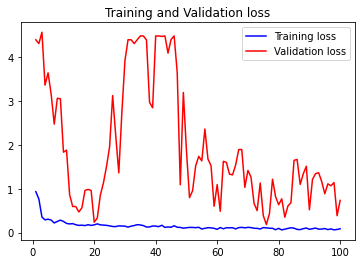

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()